# Topic Modelling

## 1. Creating dataframe

In [22]:
import pandas as pd

In [23]:
# Read CSVs, only columns of interest

## Cordis
cordish2020 = pd.read_csv("data/cordis/cordis-h2020projects.csv",sep=";",usecols=['id','objective'])
cordisfp6 = pd.read_csv("data/cordis/cordis-fp6projects.csv",sep=";",usecols=['id','objective'])
cordisfp7 = pd.read_csv("data/cordis/cordis-fp7projects.csv",sep=";",usecols=['id','objective'])
cordis = cordish2020.append(cordisfp7)
cordis = cordis.append(cordisfp6)

print('Cordis null abstracts: ',cordis['objective'].isnull().sum())
print('Cordis shape with null abstracts: ',cordis.shape)
cordis = cordis[cordis['objective'].notna()]
print('Cordis shape without null abstracts: ',cordis.shape)
cordis['objective'].isnull().sum()

Cordis null abstracts:  160
Cordis shape with null abstracts:  (68021, 2)
Cordis shape without null abstracts:  (67861, 2)


0

In [24]:
## NSF
nsf = pd.read_csv('data/nsf/nsf.csv',usecols=['AwardID','AbstractNarration'])

print('NSF null abstracts: ',nsf['AbstractNarration'].isnull().sum())
print('NSF shape with null abstracts: ',nsf.shape)
nsf = nsf[nsf['AbstractNarration'].notna()]
print('NSF shape without null abstracts: ',nsf.shape)
nsf['AbstractNarration'].isnull().sum()

NSF null abstracts:  7857
NSF shape with null abstracts:  (688506, 2)
NSF shape without null abstracts:  (680649, 2)


0

In [25]:
# Add source of documents to identifier
cordis['id'] = 'EU_' + cordis['id'].astype(str)
nsf['AwardID'] = 'NSF_' + nsf['AwardID'].astype(str)

# Rename columns to match headers later
cordis = cordis.rename(columns={'objective':'abstract'})
nsf = nsf.rename(columns={'AwardID':'id','AbstractNarration':'abstract'})

# Join dataframes into 1
corpusdata = cordis.append(nsf)
corpusdata

,id,abstract
0,EU_672890,'The project targets all luxury fashion firms ...
1,EU_633814,EU's agricultural and forestry land provides a...
2,EU_785419,"According to the Global Market Forecast, there..."
3,EU_721362,In the aerospace industry very high quality st...
4,EU_861924,Large areas of agricultural land in W. and N. ...
...,...,...
688501,NSF_1614484.0,A few micro-seconds after the Big Bang the uni...
688502,NSF_1624547.0,Calcium sulfate in crystalline form (anhydrite...
688503,NSF_1604697.0,The Rocky Mountain-Great Plains Graduate Resea...
688504,NSF_1653917.0,Investments made across national boundaries cr...


## 2. Lemmatization with Spacy

In [26]:
import spacy
from termcolor import colored

In [27]:
nlp = spacy.load('en_core_web_md')
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])
specific_stw = set(['relevant', 'simple', 'base'])

def text_preprocessing(rawtext):
    lemmatized = ' '.join([token.lemma_ for token in doc 
                           if token.is_alpha
                           and token.pos_ in valid_POS
                           and not token.is_stop
                           and token.lemma_ not in specific_stw])
    return lemmatized

In [30]:
corpusdata['lemmas'] = None

for i in range(len(corpusdata)):
    doc = nlp(corpusdata['abstract'].iloc[i])
    corpusdata['lemmas'].iloc[i] = text_preprocessing(doc)

corpusdata.head()

,id,abstract,lemmas
0,EU_672890,'The project targets all luxury fashion firms ...,project target luxury fashion firm manufacture...
1,EU_633814,EU's agricultural and forestry land provides a...,EU agricultural forestry land provide wide ran...
2,EU_785419,"According to the Global Market Forecast, there...",accord Global Market Forecast strong need ramp...
3,EU_721362,In the aerospace industry very high quality st...,aerospace industry high quality standard meet ...
4,EU_861924,Large areas of agricultural land in W. and N. ...,large area agricultural land Africa degrade wa...


In [32]:
corpusdata.to_csv('data/corpus_lemmatized.csv')

In [ ]:
corpusdata = pd.read_csv('data/corpus_lemmatized.csv')

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

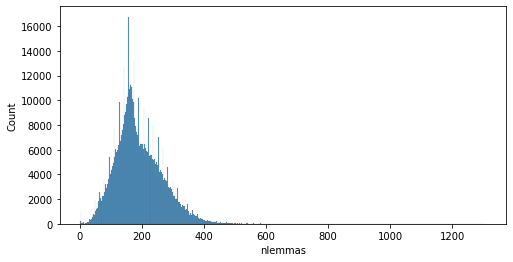

In [34]:
def count_lemmas(x):
    return len(x.split())

corpusdata['nlemmas'] = corpusdata['lemmas'].apply(count_lemmas)
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
sns.histplot(data = corpusdata, x='nlemmas')
plt.show()

In [37]:
corpusdata = corpusdata[corpusdata['nlemmas']>=100]
print('Number of projects after removing short abstracts:', len(corpusdata))

Number of projects after removing short abstracts: 679547


## 3. Vectorization with Gensim

In [47]:
corpuslemmas = corpusdata.lemmas.tolist()
corpuslemmas = list(set(corpuslemmas)) # project order lost at this point
corpuslemmas = [el.split() for el in corpuslemmas]

import gensim

# Create dictionary of tokens
D = gensim.corpora.Dictionary(corpuslemmas)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 291281 terms
First terms in the dictionary:
0 : adult
1 : alienation
2 : animate
3 : attract
4 : audio
5 : build
6 : cohort
7 : component
8 : connect
9 : consciousness


In [48]:
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

# D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=25000)
D.filter_extremes(no_below=no_below,no_above=no_above) # keep all
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 67612 terms
First terms in the dictionary:
0 : adult
1 : alienation
2 : animate
3 : attract
4 : audio
5 : build
6 : cohort
7 : component
8 : connect
9 : consciousness


In [50]:
corpusbow = [D.doc2bow(doc) for doc in corpuslemmas]

### Initial topic model

In [59]:
import os
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    !java -version
install_java()

zsh:1: command not found: apt-get
java version "15.0.2" 2021-01-19
Java(TM) SE Runtime Environment (build 15.0.2+7-27)
Java HotSpot(TM) 64-Bit Server VM (build 15.0.2+7-27, mixed mode, sharing)


In [60]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

zsh:1: command not found: wget
unzip:  cannot find or open mallet-2.0.8.zip, mallet-2.0.8.zip.zip or mallet-2.0.8.zip.ZIP.


In [61]:
os.environ['MALLET_HOME'] = 'mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet'

In [62]:
from gensim.models.wrappers import LdaMallet
ldamallet = LdaMallet(mallet_path, corpus=corpusbow, num_topics=20, id2word=D, alpha=5, iterations=100)

CalledProcessError: Command 'mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/10/3phfwz9d72540wxbxsl8ym600000gn/T/30ddd8_corpus.txt --output /var/folders/10/3phfwz9d72540wxbxsl8ym600000gn/T/30ddd8_corpus.mallet' returned non-zero exit status 127.

In [ ]:
topn = 25

fig, axes = plt.subplots(4, 5, figsize=(16, 20), sharex=True)

for i in range(5):

    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(ldamallet.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 5
    df = pd.DataFrame(ldamallet.show_topic(i+5, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 10
    df = pd.DataFrame(ldamallet.show_topic(i+10, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[2][i])
    axes[2][i].set_title('Topic ' + str(i+10))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 15
    df = pd.DataFrame(ldamallet.show_topic(i + 15, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[3][i])
    axes[3][i].set_title('Topic ' + str(i + 15))
    
plt.show()

### Cleaning vocabulary

In [ ]:
specific_stw = []

## 4. Topic modeling with Mallet